# Benchmarking Our Algorithm against others

In [1]:
import sys
sys.path.append('../../')
import numpy as np

from panav.viz import draw_env,draw_hybrid
from panav.util import flowtime

import pickle as pkl

%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
def data_to_plot(performance,metric,legends,noplot):
    xs = []
    vals = []
    labels = []
    for alg in performance:
        if alg in noplot:
            continue

        x = performance[alg]['n_agents']
        val = performance[alg][metric]

        l = min(len(x),len(val))
        x = x[:l]
        val = val[:l]
        label = legends[alg] if alg in legends else alg
        xs.append(x)
        vals.append(val)
        labels.append(label)
    return xs, vals, labels

def standard_line_chart(xs,vals,labels, colors = None):
    xticks = set()
    ymax = -1
    for i, x,val,label in zip(np.arange(len(xs)),xs,vals,labels):
        kwargs = dict(label = label,
                       marker = "o",
                       linewidth = 5 ,
                       markersize = 10) 
        
        if colors is not None and len(colors)>i:
            kwargs['color'] = colors[i]
        plt.plot(x,val, **kwargs)
       
        xticks.update(x)
        ymax = max(ymax,max(val))

    plt.xticks(list(xticks))
    plt.ylim((0,ymax*1.05))
    # plt.ylim((0,75))

def standard_bar_chart(xs,vals,labels,
                    x_gap = 3, # The gap margin between two sets of x bar bundles.
                    left_gap = 1, # The gap between the first group of x bar bundles to the origin
                    bar_width = 3, # Width of each individual bar
                    colors = None
                    ):
    N_cat = len(xs)

    bundle_width = bar_width * N_cat 

    center_dist = bundle_width + x_gap

    bar_centers  = bundle_width/2 + left_gap + np.arange(len(xs[0])) * (bundle_width +  x_gap)

    for i in range(N_cat):
        l = len(vals[i])

        kwargs = dict(label=labels[i])
        if colors is not None and len(colors)>i:
            kwargs['color'] = colors[i]

        plt.bar(bar_centers[:l]-bundle_width/2 + bar_width/2 + i * bar_width,
                vals[i],bar_width,**kwargs)

    plt.xticks(bar_centers, xs[0])
    # plt.ylim((0,100))




MultiTunnel


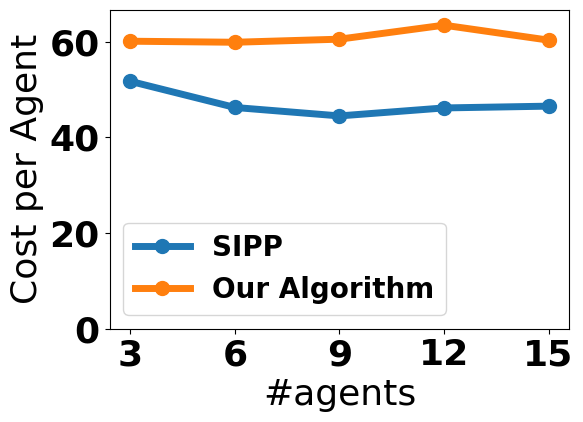

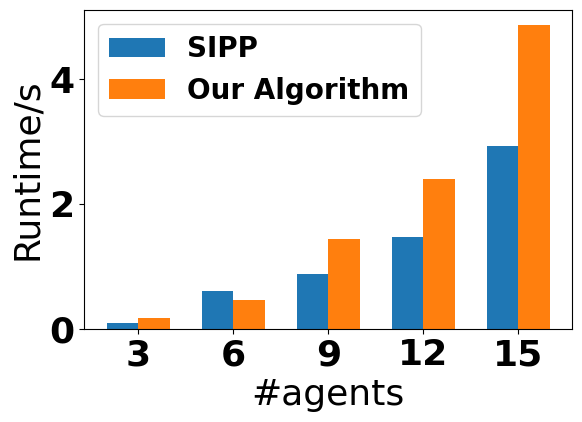

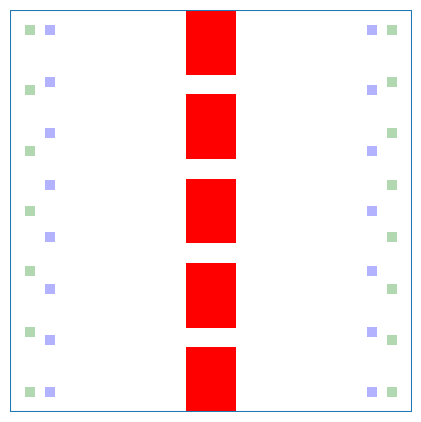

SingleTunnel


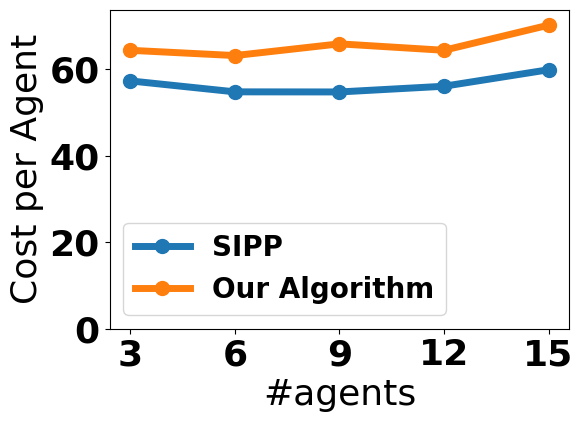

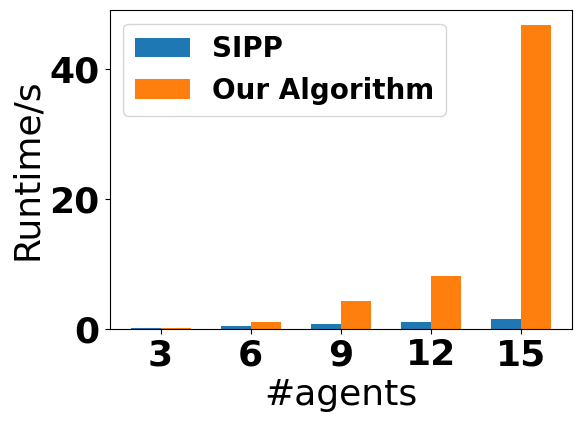

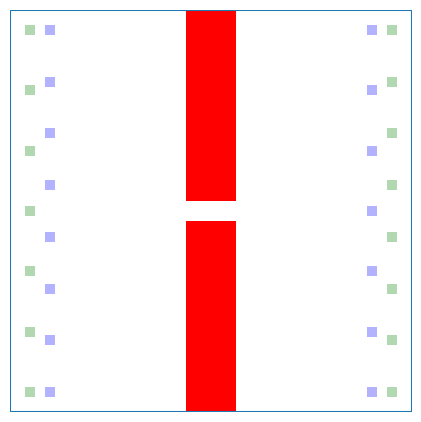

Room


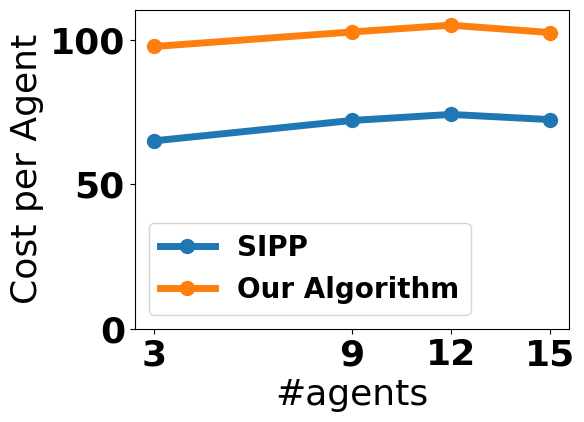

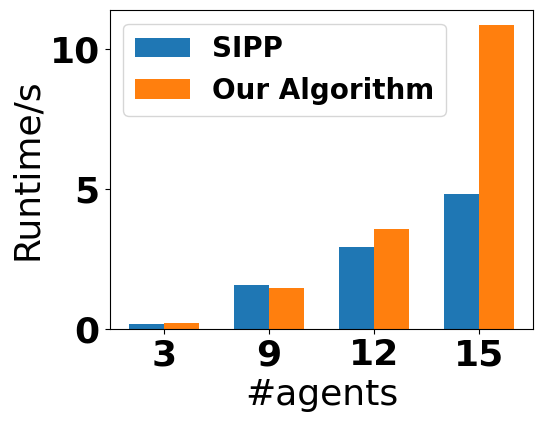

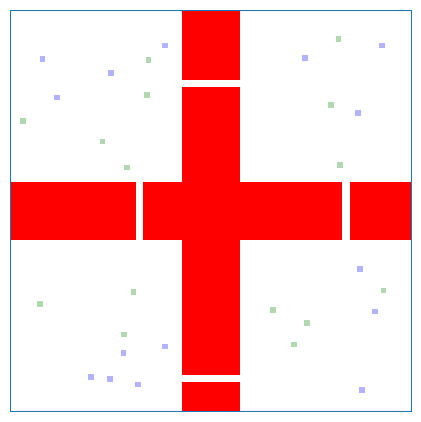

In [5]:
import os
# env_names = ["MultiTunnel","SingleTunnel", "Warehouse", "Room"]
env_names = ["MultiTunnel","SingleTunnel", "Room"]


from matplotlib import rc 
font = {'size'   : 26,'weight':'bold'}
rc('font', **font)
for ii, env_name in enumerate(env_names):
    print(env_name)
    # Make the figure saving folder

    figsave_folder = "./simFigures/"+env_name
    if env_name not in os.listdir('./simFigures'):
        os.mkdir(figsave_folder)

    # Load data
    with open("./data/{}.pkl".format(env_name),'rb') as fp:
        results = pkl.load(fp)
        results = results['results']


    TIMEOUT = 100
    # Visualize the simulation results
    metrics = {
            #     "Makespan": lambda result: [makespan(result['plan'])] if result['plan'] else [],
            #    "Flowtime": lambda result: [flowtime(result['plan'])] if result['plan'] else [],
            "Compute Time": lambda result: [result['time']] if \
                                                            'plan' in result\
                                                            and result['plan'] is not None\
                                                            and all([p is not None for p in result['plan']])\
                                                                else [],
            #    "Throuput per 60s": lambda result: [result['N_agent']/makespan(result['plan']) * 60]  if result['plan'] else [],
            "Ave. Travel Cost": lambda result: [flowtime(result['plan'])/result['N_agent']] if\
                                                 'plan' in result \
                                                 and result['plan'] is not None\
                                                and all([p is not None for p in result['plan']]) else []
            }

    legends = {
        "PIBT":"Hybrid Graph + PIBT",
        "S2M2": "S2M2",
        "PBS_Tube": "PBS + Tube MILP",
        "TAHP": "Hybrid Graph + MILP",
        "Seq_Tube": "Our Algorithm",
        "Seq_Temp_Obs": "Sequential + Simple MILP",
        "Seq_Tube_nonLazy": "Standard MILP"
    }

    color_dict = {
        "Seq_Tube": 'blue',
        "ST-RRT*": 'orange',
        "Seq_Tube_nonLazy": 'green'
    }

    noplot = {"Seq_S2M2"}
    n_to_display = [3,6,9,12,15]
    
    performance = {}

    for result in results:
        # print(result['plan'][-1])
        alg = result['alg_name']

        if alg not in performance:
            performance[alg] = {}
            performance[alg]['n_agents'] = []

        N = result['N_agent']

        if N not in n_to_display:
            continue
        
        performance[alg]['n_agents'].append(result['N_agent'])

        for metric, eval in metrics.items():
            if metric not in performance[alg]:
                performance[alg][metric] = []
            
            performance[alg][metric]+=eval(result)
    from matplotlib import pyplot as plt

    # Travel Cost per Agent
    metric = "Ave. Travel Cost"
    # plt.figure(dpi=200)
    plt.figure()

    data = data_to_plot(performance,metric,legends,noplot)
    standard_line_chart(*data,
                        # colors = list(color_dict.values())
                        )

    plt.ylabel("Cost per Agent")
    plt.xlabel("#agents")
    
    # if ii==0:
    if True:
        plt.legend(prop={'size':20})
    plt.tight_layout()

    plt.savefig(figsave_folder+"/TravelCost.pdf")

    plt.show()


    # Computational Time
    metric = "Compute Time"
    # plt.figure(dpi=200,figsize=(5,5))
    plt.figure()
    
    data = data_to_plot(performance,metric,legends,noplot)
    standard_bar_chart(*data,
                    #    colors = list(color_dict.values())
                       )
    
    plt.ylabel("Runtime/s")
    plt.xlabel("#agents")
    plt.tight_layout()


    # if ii==0:
    if True:
        plt.legend(prop={'size':20})
    
    plt.savefig(figsave_folder+"/Runtime.pdf")
   
    plt.show()

    for result in results:
        if result['N_agent'] == max(n_to_display):
            draw_env(result['env'].env,obs_alpha=1)

            plt.axis('off')
            plt.gca().get_legend().remove()
            plt.tight_layout()

            plt.savefig(figsave_folder+"/env.pdf")
            plt.show()

            break